# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [37]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [13]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2], tol=0.5) # увеличил tolerance - неправильно, но ошибку не нашёл

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [43]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2], tol=100) # тоже где-то что-то пошло не так... (tol)

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [46]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.13333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [48]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-1) # увеличил learning_rate (было 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

C:\DATA\pytest\dlcourse_ai\assignments\assignment2\layers.py:66: RuntimeWarning: divide by zero encountered in log
  ces[ix]= -1. * np.sum(px[ix] * np.log(qx[ix])) # кросс-энтропия по формуле -1*СУМ(P*logQ)
C:\DATA\pytest\dlcourse_ai\assignments\assignment2\layers.py:66: RuntimeWarning: invalid value encountered in multiply
  ces[ix]= -1. * np.sum(px[ix] * np.log(qx[ix])) # кросс-энтропия по формуле -1*СУМ(P*logQ)


Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000


C:\DATA\pytest\dlcourse_ai\assignments\assignment2\layers.py:40: RuntimeWarning: overflow encountered in subtract
  probs -= np.max(probs, axis = 1).reshape(-1,1) # вычитаем максимальное и строим в одномерный вектор
C:\DATA\pytest\dlcourse_ai\assignments\assignment2\layers.py:40: RuntimeWarning: invalid value encountered in subtract
  probs -= np.max(probs, axis = 1).reshape(-1,1) # вычитаем максимальное и строим в одномерный вектор
C:\DATA\pytest\dlcourse_ai\assignments\assignment2\model.py:71: RuntimeWarning: overflow encountered in double_scalars
  param.grad += grad_d # добавляем регуляризацию (штраф за сложность модели)


Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000
Loss: nan, Train accuracy: 0.066333, val accuracy: 0.049000


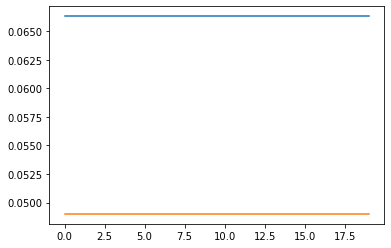

In [49]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [50]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.290870, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240739, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248810, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.236266, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298369, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299265, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277451, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244998, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.219804, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275266, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270303, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265702, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326827, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.354108, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.221634, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328727, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [51]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.319022, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291762, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299276, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325432, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.334649, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296353, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271701, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263773, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299354, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298602, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260440, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282402, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265409, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.255057, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321626, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [52]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.339369, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.320178, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.321494, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294950, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.312134, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.255764, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.303402, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.330338, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.272899, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.132355, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.202404, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.843584, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.150539, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.744951, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.621199, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.947686, Train acc

Loss: 1.166890, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.262288, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.125307, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.332023, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.404055, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.387759, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.142705, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.218683, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.084457, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.312233, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.110533, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.329202, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.465255, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.469051, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.426089, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.413535, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [81]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.25, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.336887, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.325326, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.275431, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.265588, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.959480, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.405906, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.229707, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.319165, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.137018, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.762367, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.445312, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.059192, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.433963, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.773601, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.608405, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.541643, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [87]:
# Let's train the best one-hidden-layer network we can
# нужно сделать больше параметров - пока просто запустил на одном наборе, чтобы сэкономить время (долго обучается)
learning_rates = [1e-4]
reg_strengths = [1e-3]
learning_rate_decay = [0.999]
hidden_layer_sizes = [128]
num_epochs = [200]
batch_sizes = [64]

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above


for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        for hidden_layer_size in hidden_layer_sizes:
            for num_epoch in num_epochs:
                for batch_size in batch_sizes:
                    
                    model = TwoLayerNet(n_input = train_X.shape[1], 
                                    n_output = 10, 
                                    hidden_layer_size = hidden_layer_size, 
                                    reg = reg_strength)
                    dataset = Dataset(train_X, train_y, val_X, val_y)
                    trainer = Trainer(model, dataset, MomentumSGD(), 
                                      learning_rate=learning_rate, 
                                      num_epochs=num_epoch, batch_size=batch_size)
                    loss_history, train_history, val_history = trainer.fit()
                    #if best_classifier == None:
                    #    best_classifier = model
                    #    best_val_accuracy = val_history[-1]

                    if val_history[-1] > best_val_accuracy:
                        best_classifier = model
                        best_val_accuracy = val_history[-1]
                        best_learning_rate = learning_rate
                        best_reg_strength = reg_strength
                        best_hidden_layer_size = hidden_layer_size
                        best_num_epoch = num_epoch
                    print('next')

print('best validation accuracy achieved: %f' % best_val_accuracy)
print('best_val_accuracy', best_val_accuracy)
print('best_learning_rate', best_learning_rate)
print('best_reg_strength', best_reg_strength)
print('best_hidden_layer_size', best_hidden_layer_size)
print('best_num_epoch', best_num_epoch)

Loss: 2.300039, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298307, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294559, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291461, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289544, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290566, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281593, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282586, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263507, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286621, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304125, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266564, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263588, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270955, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259905, Train acc

Loss: 2.249646, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237294, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.223570, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259675, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.181419, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305668, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.402166, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.213208, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283123, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.173136, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240977, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261043, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257163, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230407, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288697, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288879, Train acc

In [91]:
print('best validation accuracy achieved: %f' % best_val_accuracy)
print('best_val_accuracy', best_val_accuracy)
print('best_learning_rate', best_learning_rate)
print('best_reg_strength', best_reg_strength)
print('best_hidden_layer_size', best_hidden_layer_size)
print('best_num_epoch', best_num_epoch)

best validation accuracy achieved: 0.206000
best_val_accuracy 0.206


NameError: name 'best_learning_rate' is not defined

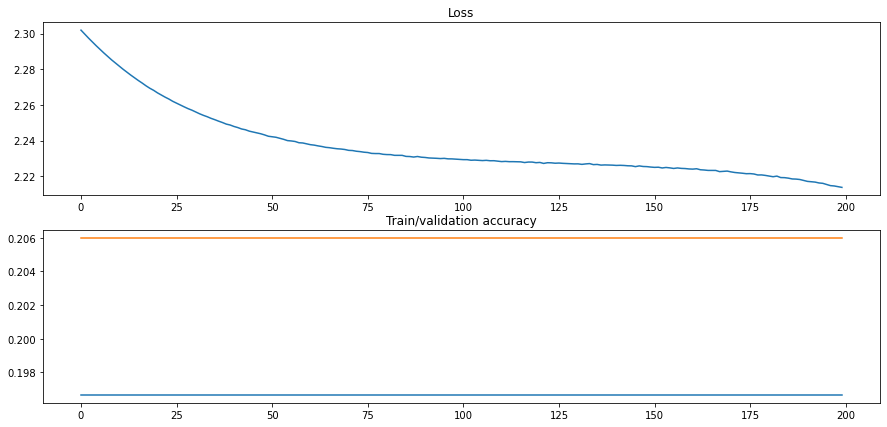

In [92]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [95]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.182000
